In [1]:
import numpy as np
from ddeint import ddeint
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse 
from scipy import stats
import math
import scipy.io
import seaborn as sns
import pyswarms as ps
import random

In [3]:
# esn helper functions
def gen_matrix(shape, sparsity, sd=1, mean=0, loc_seed=100, val_seed=100, pdf="gaussian", seeded=True):
    
    def seeded_rvs_gauss(array_len):
            return stats.norm(loc=mean, scale=sd).rvs(random_state = val_seed, size=array_len)

    def seeded_rvs_uniform(array_len):
        return stats.uniform(loc=mean, scale=sd).rvs(random_state = val_seed, size=array_len)

    m = shape[0]
    n = shape[1]

    if seeded == True:
        
        if pdf == "gaussian":
            M = scipy.sparse.random(m, n, density=sparsity, random_state=loc_seed, data_rvs=seeded_rvs_gauss).A
            return M

        if pdf == "uniform":
            M = scipy.sparse.random(m, n, density=sparsity, random_state=loc_seed, data_rvs=seeded_rvs_uniform).A
            return M

        if pdf == "ones":
            M = scipy.sparse.random(m, n, density = sparsity, random_state=loc_seed, data_rvs=np.ones).A
            return M
        else: 
            print("No such pdf")
            
    elif seeded == False:
        
        if pdf == "gaussian":
            unseeded_rvs = stats.norm(loc=mean, scale=sd).rvs
            M = scipy.sparse.random(m, n, density=sparsity, data_rvs=unseeded_rvs).A
            return M

        if pdf == "uniform":
            unseeded_rvs = stats.uniform(loc=mean, scale=sd).rvs
            M = scipy.sparse.random(m, n, density=sparsity, data_rvs=unseeded_rvs).A
            return M

        if pdf == "ones":
            M = scipy.sparse.random(m, n, density = sparsity, data_rvs=np.ones).A
            return M
        else: 
            print("No such pdf")
            
    else:
        print("Seeded was neither true nor false")


def spectral_radius(M):
    max_abs_eigenvalue = -1
    eigenvalues, eigenvectors = np.linalg.eig(M)
    for eigenvalue in eigenvalues:
        if abs(eigenvalue) > max_abs_eigenvalue:
            max_abs_eigenvalue = abs(eigenvalue)
    return max_abs_eigenvalue

def spectral_radius_matrix(M, desired_spec_rad):
    M_sr = spectral_radius(M)
    if M_sr == 0:
        return M
    else:
        M = M*(desired_spec_rad/M_sr)
        return M

def sigma(value):
    return np.tanh(value)

# esn - state equation
def state(x_prev, z_curr, A, gamma, C, s, zeta):
    z_curr = np.atleast_2d(z_curr)
    x_curr = sigma(np.matmul(A, x_prev) + gamma*np.matmul(C, z_curr) + s*zeta)
    return x_curr

# esn - observation equation
def observation(x_curr, w):
    z_next = np.matmul(np.transpose(w), x_curr)
    return z_next

def listening(training_data, x_0, A, gamma, C, s, zeta):
    state_dict = {'all_states': None,
                  'best_weight': None, 
                  'input_data': None}
    
    T = len(training_data)
    
    for t in range(1, T+1):
        if t == 1:
            x_curr = x_0
            X = np.array(x_curr)
            z_curr = training_data.loc[t]['tau17']
            Z = np.atleast_2d(np.array([z_curr]))
        else:
            x_curr = state(x_curr, z_curr, A, gamma, C, s, zeta)
            X = np.column_stack((X, x_curr))
            z_curr = training_data.loc[t]['tau17']
            Z = np.column_stack((Z, z_curr))
            
    state_dict['last_state'] = x_curr
    state_dict['all_states'] = X
    state_dict['input_data'] = Z
    
    return state_dict
    
def regression_sol(ld, state_dict, N):
    X = state_dict['all_states']
    Z = state_dict['input_data']
    
    X = X[:, 1001:]
    Z = Z[:, 1001:]

    X_transpose = X.transpose()
    Z_transpose = Z.transpose()
    XZ_transpose = np.matmul(X, Z_transpose)
    
    inverse_term = np.linalg.inv(np.matmul(X, X_transpose) + ld*np.identity(N))
    W_best = np.matmul(inverse_term, XZ_transpose)
    
    return W_best

def state_plot(state_dict, plotwith_init, node=0):
    X = state_dict.get('all_states')
    if plotwith_init == True:
        state_plot, state_ax = plt.subplots(figsize=(20,5))
        state_ax.plot(X[node][:])
        state_ax.set_title('Plot of States at node {}'.format(node))
        state_ax.set_xlabel('time')
        state_ax.set_ylabel('state of node {}'.format(node))
        
        return (np.amin(X[node][:]), np.amax(X[node][:]))
    
    if plotwith_init == False:
        state_plot, state_ax = plt.subplots(figsize=(20,5))
        state_ax.plot(X[node][1001:])
        state_ax.set_title('Plot of States at node {}'.format(node))
        state_ax.set_xlabel('time')
        state_ax.set_ylabel('state of node {}'.format(node))
    
        return (np.amin(X[node][1001:]), np.amax(X[node][1001:]))
                
def prediction(state_dict, weight, testing_data, training_data, A, gamma, C, s, zeta):
    prediction_dict = {'testing_error': None,
                       'z_actuals': None,
                       'z_predictions': None}
    
    z_actuals = []
    z_predictions = []
    
    last_state = state_dict.get('last_state')
    testing_error = 0
    
    T = len(training_data)
    T_bar = len(testing_data)
    
    x_prev = last_state
    for t_bar in range(T+1, T+T_bar+1):
        z_predict = observation(x_prev, weight)[0][0]
        x_prev = state(x_prev, z_predict, A, gamma, C, s, zeta)
        z_predictions.append(z_predict)
        
        z_actual = testing_data.loc[t_bar]['tau17']
        testing_error = testing_error + (z_predict - z_actual)**2
        z_actuals.append(z_actual)
        
    testing_error = testing_error/T_bar
    
    prediction_dict['testing_error'] = testing_error
    prediction_dict['z_actuals'] = z_actuals
    prediction_dict['z_predictions'] = z_predictions        
        
    return prediction_dict

def training_error(state_dict, weight, training_data, remove_init=True):
    training_error_dict = {'training_error': None,
                           'z_actuals': None,
                           'z_predictions': None}
    
    z_actuals = []
    z_predictions = []
    
    X = state_dict.get('all_states')
    
    X = X[:, 1001:]
    
    training_error = 0
    
    T = len(training_data)
    
    for t in range(1001, T):
        x_prev = X[:, t-1001]
        z_predict = observation(x_prev, weight)[0]
        
        z_predictions.append(z_predict)
        z_actual = training_data.loc[t]['tau17']
        z_actuals.append(z_actual)
        training_error = training_error + (z_predict - z_actual)**2
        
    training_error = training_error/(T-1000)
    
    training_error_dict['training_error'] = training_error
    training_error_dict['z_actuals'] = z_actuals
    training_error_dict['z_predictions'] = z_predictions
        
    return training_error_dict

# helper functions to generate data set (Mackey-Glass)
def mantas_data():
    # load data from matlab file mackeyglass time series
    loaded_mat = scipy.io.loadmat('MGTimeseries_dde23_tau17.mat')
    data_tau17 = loaded_mat['MGseries_dde23_tau17'][0]
    data_tau50 = loaded_mat['MGseries_dde23_tau50'][0]

    # clean dataset
    data = pd.DataFrame({'tau17': data_tau17}) # use tau=17 first
    data.index = data.index + 1

    # split data set
    training_data = data.loc[1:3001]
    testing_data = data.loc[3002:]
    
    return training_data, testing_data

def generate_MG_data(init_val, tau, a, b, n):
    def MackeyGlass(z, t):
        return (a * z(t - tau)) / (1 + z(t - tau)**n) - b*z(t)

    def initial(t):
        return init_val

    time_space = np.arange(0, 5000, 1)

    z_solution_new = ddeint(MackeyGlass, initial, time_space)
    z_solution_new  = [ x[0] for x in z_solution_new[1:] ]
    z_solution_new.insert(0, init_val)
    z_solution_new = [ np.tanh(val-1) for val in z_solution_new ]
    z_sol_new_df = pd.DataFrame(z_solution_new, columns=['tau17'])

    z_sol_new_df.index = z_sol_new_df.index + 1
    training_data = z_sol_new_df.loc[1:3001]
    testing_data = z_sol_new_df.loc[3002:]
    
    return training_data, testing_data

def hist_accuracy_plot(actuals, predictions, with_bars=False):
    if with_bars == False:
        sns.kdeplot(actuals, label='actual', shade=True, color='red')
        sns.kdeplot(predictions, label='prediction', shade=True, color='skyblue')
        plt.legend()
        
    if with_bars == True:
        sns.histplot(actuals, label='actual', color='red', kde=True)
        sns.histplot(predictions, label='prediction', color='skyblue', kde=True)
        plt.legend()

In [4]:
def listening_2states(training_data, x_0, A, gamma, C, s, zeta):
    state_dict = {'all_states': None,
                  'best_weight': None, 
                  'input_data': None}
    
    T = len(training_data)
    
    for t in range(1, T+1):
        if t == 1:
            x_curr = x_0
            X = np.array(x_curr)
            z_curr = training_data.loc[t]['tau17']
            Z = np.atleast_2d(np.array([z_curr]))
        else:
            x_curr = state(x_curr, z_curr, A, gamma, C, s, zeta)
            X = np.column_stack((X, x_curr))
            z_curr = training_data.loc[t]['tau17']
            Z = np.column_stack((Z, z_curr))

    X_toprow = np.delete(X, 0, 1) 
    x_T = state(x_curr, z_curr, A, gamma, C, s, zeta)
    X_toprow = np.column_stack((X_toprow, x_T))
    
    X = np.vstack((X_toprow, X))
            
    state_dict['last_state'] = x_curr
    state_dict['all_states'] = X
    state_dict['input_data'] = Z
    
    return state_dict

def prediction_2states(state_dict, weight, testing_data, training_data, A, gamma, C, s, zeta, platt_err):
    prediction_dict = {'testing_error': None,
                       'z_actuals': None,
                       'z_predictions': None}
    
    z_actuals = []
    z_predictions = []
    
    T = len(training_data)
    T_bar = len(testing_data)
    
    X = state_dict['all_states']
    x_k_km1 = X[:,[-1]]
    x_prev = state_dict['last_state']
    
    testing_error = 0
    
    for t_bar in range(T+1, T+T_bar+1):
        z_predict = observation(x_k_km1, weight)[0][0]
        x_curr = state(x_prev, z_predict, A, gamma, C, s, zeta)
        x_k_km1 = np.vstack((x_curr, x_prev))
        x_prev = x_curr
        z_predictions.append(z_predict)
        
        z_actual = testing_data.loc[t_bar]['tau17']
        z_actuals.append(z_actual)
        
        if platt_err == True:
            testing_error = testing_error + ((z_predict - z_actual)**2)*np.exp(-((t_bar-T)/T_bar))
        else:    
            testing_error = testing_error + (z_predict - z_actual)**2
    
    if platt_err == True:
        prediction_dict['testing_error'] = testing_error
        
    else: 
        testing_error = testing_error/T_bar
        prediction_dict['testing_error'] = testing_error
    
    prediction_dict['z_actuals'] = z_actuals
    prediction_dict['z_predictions'] = z_predictions        
        
    return prediction_dict

def regression_sol_2states(ld, state_dict, N):
    X = state_dict['all_states']
    Z = state_dict['input_data']
    
    X = X[:, 1001:]
    Z = Z[:, 1001:]

    X_transpose = X.transpose()
    Z_transpose = Z.transpose()
    XZ_transpose = np.matmul(X, Z_transpose)
    
    inverse_term = np.linalg.inv(np.matmul(X, X_transpose) + ld*np.identity(2*N))
    W_best = np.matmul(inverse_term, XZ_transpose)
    
    return W_best

In [5]:
data = generate_MG_data(1.2, 17, 0.2, 0.1, 10)
training_data = data[0]
testing_data = data[1]

/Users/hannah/Library/Python/3.8/lib/python/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([g(tt[0])] + results)


In [ ]:
def esn(params):
    N = 1000
    ld = 10**(-1*params[0])
    C = gen_matrix(shape=(N,1), sparsity=params[1], sd=4, mean=-2, pdf="uniform", seeded=False)
    gamma = params[2]
    A = gen_matrix(shape=(N,N), sparsity=0.01, sd=2, mean=-1, pdf="uniform", seeded=False)
    spec_rad = params[3]
    A = spectral_radius_matrix(A, spec_rad)
    s = params[4]
    zeta = gen_matrix(shape=(N,1), sparsity=params[1], pdf="ones", seeded=False)
    x_0 = np.zeros(shape=(N,1), dtype=float)

    state_dict = listening_2states(training_data, x_0, A, gamma, C, s, zeta)
    weight_result = regression_sol_2states(ld, state_dict, N) 

    predicting = prediction_2states(state_dict, weight_result, testing_data, training_data, A, gamma, C, s, zeta, True)
    
    return predicting['testing_error']

def f(x):
    n_particles = x.shape[0]
    j = [esn(x[i]) for i in range(n_particles)]
    return np.array(j)

options = {'c1': 1, 'c2': 1, 'w':1}

#middle = (3, 0.9, 2.4, 0.03, 1.7, 0.3, 0.85)
#max_bound = tuple([sum(x) for x in zip(middle, (0.5, 0.05, 2, 0.005, 0.2, 0.2, 0.1))])
#min_bound = tuple([sum(x) for x in zip(middle, (-0.5, -0.1, -2, -0.005, -0.2, -0.2, -0.1))])
#bounds = (min_bound, max_bound)

max_bound = (20, 1, 3, 2, 0.5)
min_bound = (10, 0.1, 0.1, 0.1, 0.1)
bounds = (min_bound, max_bound)

completed = False
while completed == False:
    try:
        optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=5, options=options, bounds=bounds)
        cost, pos = optimizer.optimize(f, iters=10)
        competed = True
        #print('Completed a run with cost {}'.format(cost))
        #if cost < 0.04:
            #completed = True
    except np.linalg.LinAlgError:
        print("Singular matrix occurred. Best positions obtained were {} with error {}".format(pos, cost))

In [11]:
pos_ls = list(pos)

In [12]:
print(pos_ls)

[0.5873635438374532, 0.8294779906557893, 2.4628362347316655, 1.6006400817370048, 0.24910724728958236]


In [6]:
pos_ls = [10, 0.5, 2.5, 1.6, 0.2]

Training error:  0.001098290070969981
Testing error:  215.62815936496693


(-0.9492260624173725, 0.960166316644015)

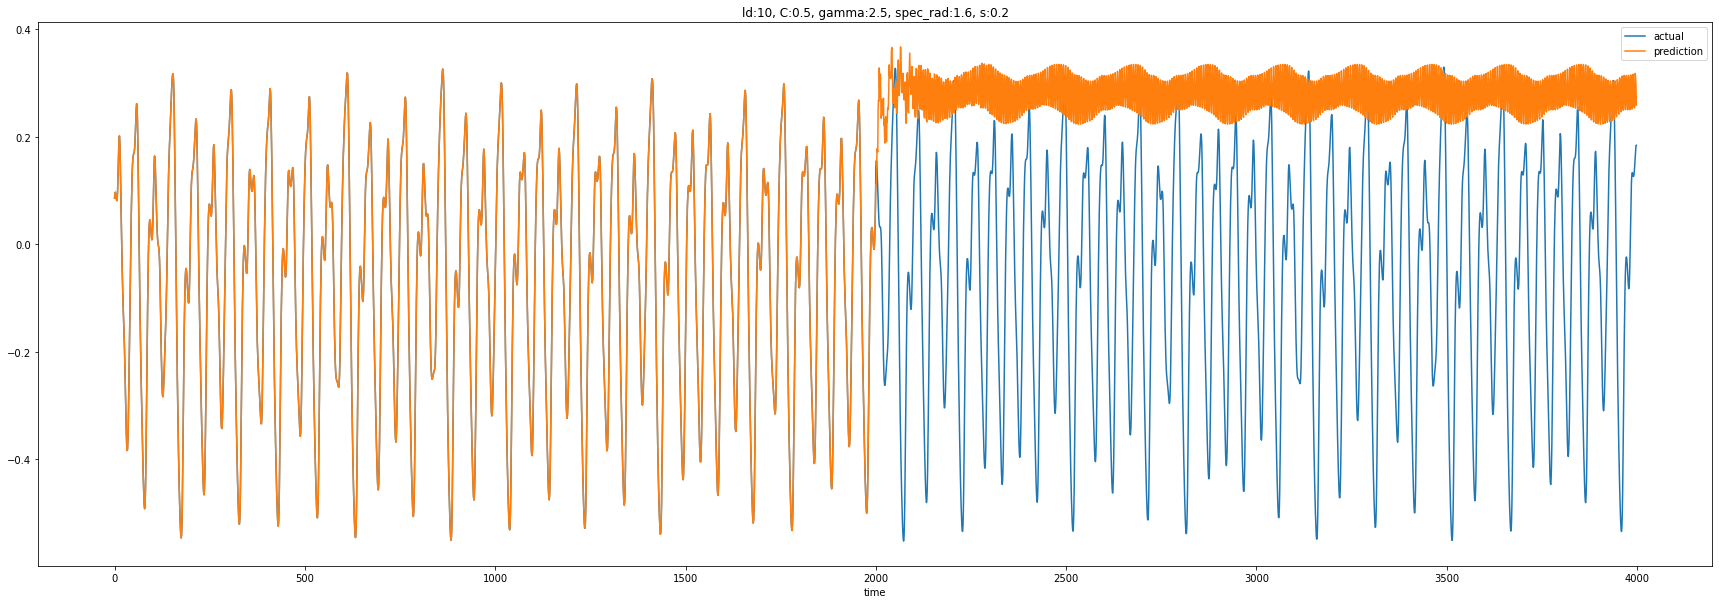

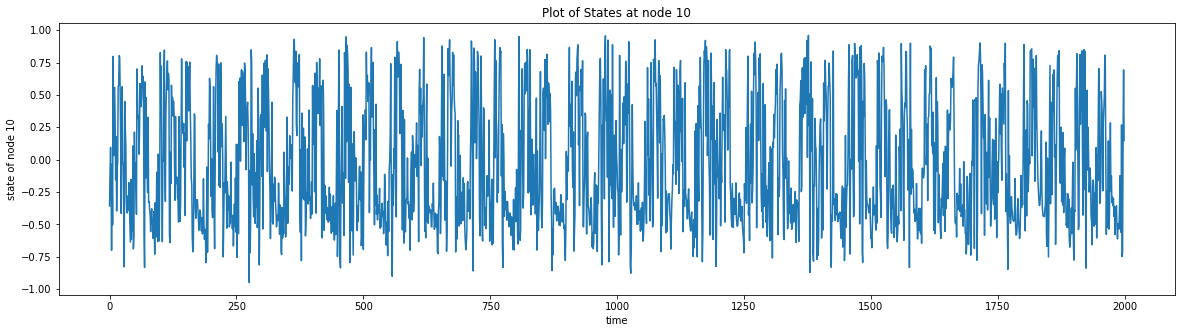

In [7]:
N = 1000
ld = 10**(-1*pos_ls[0])
C = gen_matrix(shape=(N,1), sparsity=pos_ls[1], sd=4, mean=-2, pdf="uniform", seeded=False)
gamma = pos_ls[2]
A = gen_matrix(shape=(N,N), sparsity=0.01, sd=2, mean=-1, pdf="uniform", seeded=False)
spec_rad = pos_ls[3]
A = spectral_radius_matrix(A, spec_rad)
s = pos_ls[4]
zeta = gen_matrix(shape=(N,1), sparsity=pos_ls[1], pdf="ones", seeded=False)
x_0 = np.zeros(shape=(N,1), dtype=float)

state_dict = listening_2states(training_data, x_0, A, gamma, C, s, zeta)
weight_result = regression_sol_2states(ld, state_dict, N) 

training = training_error(state_dict, weight_result, training_data)
predicting = prediction_2states(state_dict, weight_result, testing_data, training_data, A, gamma, C, s, zeta, True)

print("Training error: ", training['training_error'])
print("Testing error: ", predicting['testing_error'])

z_actuals = training['z_actuals'] + predicting['z_actuals']
z_predictions = training['z_actuals'] + predicting['z_predictions']

forecast_plot, forecast_ax = plt.subplots(figsize=(30, 10))
forecast_ax.plot(z_actuals, label='actual')
forecast_ax.plot(z_predictions, label='prediction')
forecast_ax.set_title('ld:{}, C:{}, gamma:{}, spec_rad:{}, s:{}'.format(*pos_ls))
forecast_ax.set_xlabel('time')
forecast_ax.legend()

state_plot(state_dict, plotwith_init=False, node=10)

In [ ]:
n_iters = 0
while n_iters <= 200:
    ld_rand = random.randint(5, 15)
    C_spars_rand = round(random.uniform(0.1, 1), 1)
    gamma_rand = round(random.uniform(0.1, 1), 1)
    spec_rad_rand = round(random.uniform(0.1, 2), 1)
    s_rand = round(random.uniform(-1, 1), 1)

    pos_ls = [ld_rand, C_spars_rand, gamma_rand, spec_rad_rand, s_rand]

    N = 1000
    ld = 10**(-1*params[0])
    C = gen_matrix(shape=(N,1), sparsity=params[1], sd=4, mean=-2, pdf="uniform", seeded=False)
    gamma = params[2]
    A = gen_matrix(shape=(N,N), sparsity=0.01, sd=2, mean=-1, pdf="uniform", seeded=False)
    spec_rad = params[3]
    A = spectral_radius_matrix(A, spec_rad)
    s = params[4]
    zeta = gen_matrix(shape=(N,1), sparsity=params[1], pdf="ones", seeded=False)
    x_0 = np.zeros(shape=(N,1), dtype=float)

    state_dict = listening_2states(training_data, x_0, A, gamma, C, s, zeta)
    weight_result = regression_sol_2states(ld, state_dict, N) 

    #training = training_error(state_dict, weight_result, training_data)
    predicting = prediction_2states(state_dict, weight_result, testing_data, training_data, A, gamma, C, s, zeta, True)

    #print("Training error: ", training['training_error'])
    #print("Testing error: ", predicting['testing_error'])

    z_actuals = predicting['z_actuals']
    z_predictions = predicting['z_predictions']

    forecast_plot, forecast_ax = plt.subplots(figsize=(30, 10))
    forecast_ax.plot(z_actuals, label='actual')
    forecast_ax.plot(z_predictions, label='prediction')
    forecast_ax.set_title('ld:{}, C:{}, gamma:{}, A:{}, spec_rad:{}, s:{}, zeta:{}'.format(*pos_ls))
    forecast_ax.set_xlabel('time')
    forecast_ax.legend()

    state_plot(state_dict, plotwith_init=False, node=10)
    
    n_iters = n_iters + 1

(-0.5023653839944988, 0.5960542841202111)

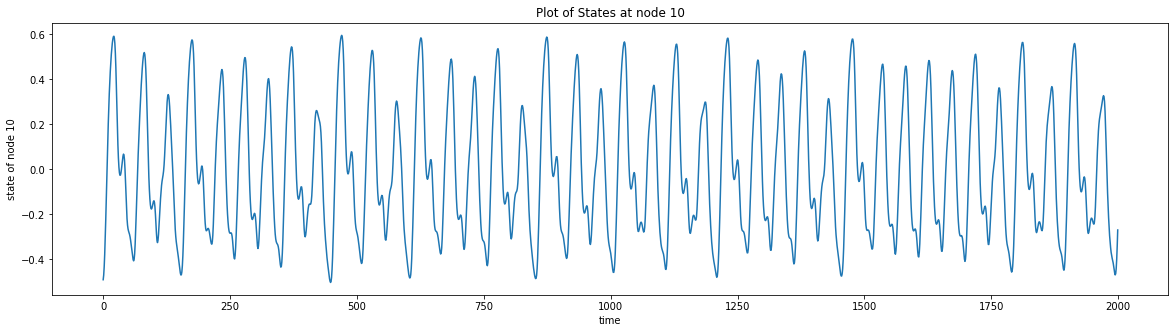

In [75]:
state_plot(state_dict, plotwith_init=False, node=10)

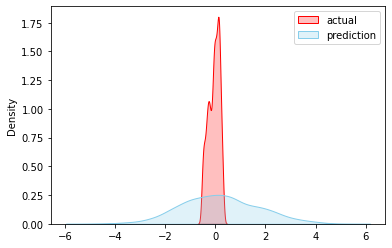

In [19]:
hist_accuracy_plot(z_actuals, z_predictions)